## ChatGPT Labelling

#### Glossary

1. ChatGPT API Connection
2. Verification of the labelling on text already labelled by us
3. Labelling by ChatGPT

In [1364]:
#!pip install openai
#!pip install langchain
#!pip install python-Levenshtein

In [1365]:
import re
import ast
import pickle
import Levenshtein
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from ecbdata import ecbdata
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from openai import OpenAI
from jinja2 import Template

tqdm.pandas()

#ECB Color
color = (17/255, 49/255, 147/255)

In [1366]:
# Set your OpenAI API key
api_key = open("C:\\Users\\School\\Desktop\\GPT_KEY.txt", "r").read()

In [1367]:
# Functions:
# Function to count the frequency of words from the list in a sentence
def count_frequency(answer, words_to_match):
    if pd.isna(answer):
        return 0
    sentence_lower = answer.lower()
    return sum(sentence_lower.count(word) for word in words_to_match)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_end_answer(text):
    text = text.replace(r'[end_answer]', '')
    return text

def remove_special_characters_keep_point(text):
    # Define the regex pattern to match special characters except "."
    pattern = r"[^\w\s\.\']"
    # Replace special characters with an empty string
    text = re.sub(pattern, '', text)
    # Replace consecutive dots with just one dot
    text = re.sub(r'\.{2,}', '.', text)
    return text

# Function to extract sentences containing specific words
def extract_sentences(text, words_to_match):
    # Compile regex pattern to split text into sentences
    sentence_pattern = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s')
    
    sentences = sentence_pattern.split(text)
    return [sentence for sentence in sentences if any(word in sentence for word in words_to_match)]

def remove_unnecessary_spaces(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def remove_starting_month(text):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    pattern = r'^(' + '|'.join(months) + r')\s'
    text = re.sub(pattern, '', text)
    return text

def remove_special_characters(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return cleaned_text

# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [1368]:
# Import dataset containing the interveiw data
df = pd.read_csv('Final_Working_Data_with_GPT_Output.csv')

### Prepare the data for the labeling

In [1369]:
def preprocess_text(df,words_to_match):
        text_preproc = (
                df.Answers
                .astype(str)
                .progress_apply(lambda row: remove_end_answer(row))
                .progress_apply(lambda row: remove_special_characters_keep_point(row))
                .progress_apply(lambda row: remove_unnecessary_spaces(row))
                .progress_apply(lambda row: remove_starting_month(row))
                .progress_apply(lambda row: extract_sentences(row,words_to_match)))

        df["Sentences"]=text_preproc

        return df

df = preprocess_text(df, words_to_match=words_to_match)

100%|██████████| 519/519 [00:00<00:00, 1512.65it/s]


In [1370]:
df["Frequency"] = df["Answers"].apply(count_frequency, words_to_match=words_to_match)
df['Sentences_len'] = df['Sentences'].apply(len)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


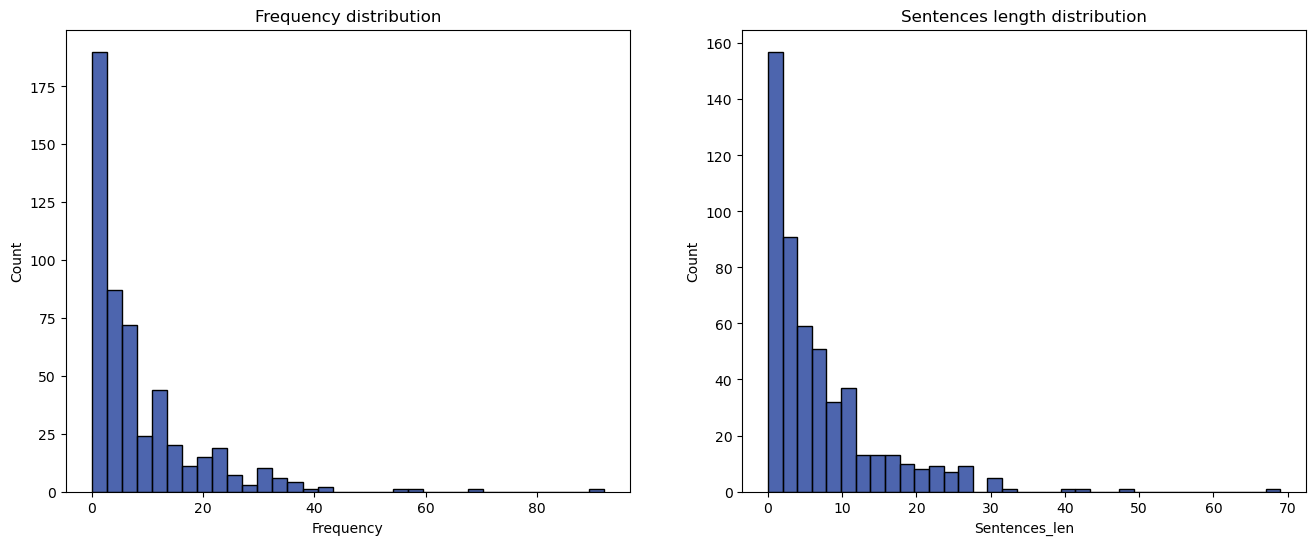

In [1371]:
# Plot the distribution of Frequency and Sentences_len
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df["Frequency"], ax=ax[0], color=color)
ax[0].set_title("Frequency distribution")
sns.histplot(df["Sentences_len"], ax=ax[1], color=color)
ax[1].set_title("Sentences length distribution")
plt.show()

### Keep only labeled data, to test GPT perfromance

In [1372]:
# Dataframe with the labeled Metaphors
df_labels = df[df['Metaphors'].notnull()].copy()
print("Shape of the dataset with labeled Metaphors: ", df_labels.shape)

Shape of the dataset with labeled Metaphors:  (68, 26)


In [1373]:
# This cell could be unnecessay in later versions

# lambda function to convert string representations of lists into actual lists
parse_list = lambda x: ast.literal_eval(x) if x != '[\'None\']' else []
df_labels.loc[:, 'Metaphors Sentence'] = df_labels['Metaphors Sentence'].apply(parse_list)

# lambda function to count the elements in each list
df_labels.loc[:, 'Metaphors_len'] = df_labels['Metaphors Sentence'].apply(len)

In [1374]:
# Print total number of Metaphors
print("Total number of Metaphors (Label): ", df_labels['Metaphors_len'].sum())
print("Total number of Sentences (with words_to_match): ", df_labels['Sentences'].apply(len).sum())
print("Average number of Metaphors per Interview: ", df_labels['Metaphors_len'].mean())
print("Ratio of Metaphors to Sentences: ", df_labels['Metaphors_len'].sum() / df_labels['Sentences'].apply(len).sum())

Total number of Metaphors (Label):  493
Total number of Sentences (with words_to_match):  574
Average number of Metaphors per Interview:  7.25
Ratio of Metaphors to Sentences:  0.8588850174216028


In [1375]:
df_labels.head()

,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,list_regex_reduced_len,text_length,pos_metaphors,pos_metaphors_len,Sentences,Frequency,Sentences_len,Sentence_GPT,Category_GPT,Metaphors_len
47,47,2009-09-12,"Interview with the ""Junge Zeitung“ of the Fran...",Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,NaN,"Mr. President, as „Mr. Euro“: How many Euros d...","['fear deflation', 'inflation below', 'preserv...","[Or does the ECB fear deflation, Our definitio...",...,5,11198,[],0,"[At the moment there is no inflation., Can you...",7,5,['since the inception of the single currency w...,"['warfare', 'sports']",5
65,65,2010-04-24,Interview with Expresso,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,Are we really leaving the crisis behind or are...,As regards the conjuncture in the real economy...,['None'],[],...,0,12101,[],0,[],0,0,[],[],0
73,73,2011-10-18,Interview with Frankfurter Allgemeine Zeitung,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,"Mr Trichet, do you believe in destiny?[end_que...",I have used that term on a few occasions – inc...,"['experience of hyperinflationr', 'experienced...","[As regards inflation, I understand the deep-s...",...,6,12782,"[('annual', 'inflation')]",1,[Average annual inflation has at 2.0 over the ...,9,6,['as regards inflation i understand the deepse...,"['disease', 'orientation']",4
79,79,2011-09-20,Interview with Expansión,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,1. At the last meeting you said that the risks...,At the last meeting of the Governing Council w...,"['upside risks to inflation', 'materialisation...","[On the other hand, in July there were upside ...",...,2,7295,[],0,[On the other hand in July there were upside r...,3,2,['on the other hand in july there were upside ...,"['orientation', 'warfare']",3
85,85,2011-06-16,Interview with The Times,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,The Times: There are two camps: one that empha...,Jean-Claude Trichet: All advanced economies ar...,"['anchor very solidly inflation', 'materialisa...",[What I would say is that in our case it is ve...,...,6,10455,"[('annual', 'inflation')]",1,[Annual average inflation over the past 12 yea...,12,6,['what i would say is that in our case it is v...,"['orientation', 'orientation', 'sports', 'spor...",5


### 1. ChatGPT API Connection


In [1376]:
initial_prompt = """
Title: Conceptual Metaphor Detection

Description: Detect and extract conceptual Metaphors in a set of sentences.

Task: Given a set of sentences, you are required to identify and extract conceptual metaphors present.  
Only consider conceptual metaphors related to inflation, deflation, inflationary, disinflationary, hyperinflation, and disinflation.
After identifying the metaphors, return the sentences that contain the metaphors and label it in the format:

Sentence: [Sentence text] Category: [Category]

Where, Category is one of the following (with a set of examples):
Fire = ['ignite', 'fuel', 'spark', 'dampen', 'stoke', 'kindle', 'choke', 'stifle', 'fan', 'flare-up', 'douse', 'snuff']
Liquids = ['erode', 'surge', 'subside', 'simmers', 'emergence', 'ebb', 'dilute', 'spurt', 'recede', 'buoy']
Plant = ['hedge','nip']
Animal = ['soar', 'rampant', 'curb', 'tame', 'rein', 'creep', 'whip', 'gallop', 'halt', 'roar', 'curtail', 'gnaw', 'hibernation','Pounce','Stalk','Bite','Claw','Snarl','Charge','Hunt','Intimidate','Defend','Rend','Tear','Dominated','Fangs','Claws','Predation','Territoriality','Hackles','Prowess','Strength','Ferocity','Dominance','Menace','Threat','piercing','glaring','Talons','Paws','Horns','Tusks','Fierce','Savage','Ruthless','Daunting','Wild','Untamed','Ferocious','prey']
Disease = ['plague', 'worsen', 'benign', 'virulent', 'debilitate', 'bout', 'chronically']
Warfare = ['threat', 'subdue', 'target', 'beat', 'preempt', 'vigilant', 'ravage', 'undermine', 'forestall', 'counteract', 'eliminate', 'ferocious', 'ruinous', 'clobber', 'buster', 'eradicate', 'besieged', 'thwart', 'bash', 'beset']
Sports = ['pace', 'outstrip', 'lag', 'surpass', 'quicken', 'outrun', 'bout', 'best', 'tug-of-war', 'zip', 'overtake']
Machine = ['accelerate', 'faster', 'control', 'slow', 'trigger', 'skyrocket', 'rapid', 'heat', 'escalate', 'decelerate', 'ratchet', 'unchecked', 'readjusted', 'chug', 'damper', 'zoom']
Orientation = ['low', 'rise', 'high', 'increase', 'reduce', 'decline', 'fall', 'exceed', 'spiral', 'hyper', 'upward', 'uptick', 'downward', 'boost', 'peak', 'diminish', 'upturn', 'hike', 'plummet', 'upswing']
Other = [any other metaphor not covered by the above categories]

Definition: Conceptual metaphors refer to linguistic expressions that metaphorically represent abstract concepts in terms of more concrete concepts.

Identifying Metaphorical and Non-Metaphorical Usage:
To identify whether the use of "inflation" is metaphorical or non-metaphorical, consider the following questions:

Is another domain being used to describe inflation?: Check if the sentence draws on concepts from a different area of experience to explain or depict inflation.
Metaphorical: "Inflation is eroding our savings." (Here, "eroding" draws on the domain of natural wear and tear, often associated with physical erosion.)
Non-Metaphorical: "Inflation is measured by the Consumer Price Index." (This is a straightforward, literal description.)

Is the language used more concrete and vivid?: Metaphors often use vivid and concrete imagery to make abstract ideas more relatable.
Metaphorical: "Inflation is a beast that must be tamed." (The use of "beast" provides a vivid and concrete image.)
Non-Metaphorical: "Inflation affects the purchasing power of money." (This is a direct explanation without vivid imagery.)

Is the purpose to simplify and relate?: Metaphors are often used to simplify complex ideas and relate them to common experiences.
Metaphorical: "The economy is overheating due to inflation." (This uses the concept of overheating, which is a familiar experience, to explain economic stress.)
Non-Metaphorical: "High inflation rates can lead to increased interest rates." (This is a factual statement explaining a cause-and-effect relationship.)

Additional Instructions:
- If one sentence contains multiple metaphors, return the sentence multiple times with each metaphor labeled separately.

Example Input:
["China worries that such rapid growth could ignite inflation, and the countrys banking industry has been trying since last year to bring the rate down to 7 percent a year.",
"But the evidence from that earlier period is tainted by the fact that inflation was roaring at the time creating bracket creep, over-taxation of illusory capital gains and paper profits, and rising interest rates."]

Example Output:
Sentence: "China worries that such rapid growth could ignite inflation, and the countrys banking industry has been trying since last year to bring the rate down to 7 percent a year." Category: Fire, 
Sentence: "But the evidence from that earlier period is tainted by the fact that inflation was roaring at the time creating bracket creep, over-taxation of illusory capital gains and paper profits, and rising interest rates." Category: Animal

The output has to be in the right format as shown in the example output. The categories are predefined and you have to choose the right category based on the metaphor used in the sentence.
"""

following_prompts = """
Detect and extract the conceptual metaphors related to inflation, deflation, inflationary, disinflationary, hyperinflation, and disinflation in the following sentences:
{{list_sentences}}

Return the metaphors in the format:
Sentence: [Sentence text] Category: [Category]

Where, Category is one of the following:
Fire, Liquids, Plant, Animal, Disease, Warfare, Sports, Machine, Orientation, Other

The output has to be in the right format. The categories are predefined and you have to choose the right category based on the metaphor used in the sentence.
"""

following_prompts = Template(following_prompts)

In [1377]:
df_labels["Sentences"].iloc[3]

['On the other hand in July there were upside risks to inflation but now they are balanced.',
 'This is a major asset for Europe it protects us from the materialisation of the risk of inflation as well as the materialisation of the risk of deflation.']

In [1378]:
print(following_prompts.render(list_sentences=df["Sentences"].iloc[2]))

# Limit size of df to 10
#df_labels = df_labels.iloc[:10]

sentences_list = []

for index, row in df.iterrows():
    sentences = row["Sentences"]
    if len(sentences) > 0:
        sentences_list.append(sentences)

print(len(sentences_list))


Detect and extract the conceptual metaphors related to inflation, deflation, inflationary, disinflationary, hyperinflation, and disinflation in the following sentences:
['If longterm interest rates remain at a low level as a result of favourable inflation expectations influenced by a credible monetary policy oriented towards price stability and as a consequence of the impact of other factors then the effect on economic activity of a rise in shortterm interest rates is going to be more muted.', 'Public perceptions and expectations of future inflation should be favourably influenced by a change in the monetary policy stance that aims at preserving price stability.', 'It a higher level of interest rates could foster expectations of lower inflation and higher real disposable incomes and increase confidence particularly in countries where public perceptions of current inflation are less favourable than actual inflation and financial markets inflation expectations.', 'It was necessary in or

In [1379]:
all_prompts = [initial_prompt] + [following_prompts.render(list_sentences=sentences) for sentences in sentences_list]
all_prompts

['\nTitle: Conceptual Metaphor Detection\n\nDescription: Detect and extract conceptual Metaphors in a set of sentences.\n\nTask: Given a set of sentences, you are required to identify and extract conceptual metaphors present.  \nOnly consider conceptual metaphors related to inflation, deflation, inflationary, disinflationary, hyperinflation, and disinflation.\nAfter identifying the metaphors, return the sentences that contain the metaphors and label it in the format:\n\nSentence: [Sentence text] Category: [Category]\n\nWhere, Category is one of the following (with a set of examples):\nFire = [\'ignite\', \'fuel\', \'spark\', \'dampen\', \'stoke\', \'kindle\', \'choke\', \'stifle\', \'fan\', \'flare-up\', \'douse\', \'snuff\']\nLiquids = [\'erode\', \'surge\', \'subside\', \'simmers\', \'emergence\', \'ebb\', \'dilute\', \'spurt\', \'recede\', \'buoy\']\nPlant = [\'hedge\',\'nip\']\nAnimal = [\'soar\', \'rampant\', \'curb\', \'tame\', \'rein\', \'creep\', \'whip\', \'gallop\', \'halt\',

In [1380]:
all_prompts = [[{"role": "system", "content": prompt}] for prompt in all_prompts]
#all_prompts

In [1381]:
"""client = OpenAI(api_key=api_key)

gpt_answer = [client.chat.completions.create(messages=msg, model='gpt-4o').choices[0].message.content for msg in all_prompts]"""

"client = OpenAI(api_key=api_key)\n\ngpt_answer = [client.chat.completions.create(messages=msg, model='gpt-4o').choices[0].message.content for msg in all_prompts]"

In [1382]:
"""gpt_answer
print(len(gpt_answer))"""

'gpt_answer\nprint(len(gpt_answer))'

In [1383]:
"""# Save the GPT-4 output to a pickle file
with open('gpt_answer_all.pkl', 'wb') as f:
    pickle.dump(gpt_answer, f)"""

"# Save the GPT-4 output to a pickle file\nwith open('gpt_answer_all.pkl', 'wb') as f:\n    pickle.dump(gpt_answer, f)"

In [1384]:
# Load the GPT-4 output from the pickle file
with open('gpt_answer.pkl', 'rb') as f:
    gpt_answer = pickle.load(f)

gpt_answer

['Sure, here are the conceptual metaphors extracted from the given sentences along with their respective categories:\n\n### Input:\n1. "China worries that such rapid growth could ignite inflation, and the country\'s banking industry has been trying since last year to bring the rate down to 7 percent a year."\n2. "But the evidence from that earlier period is tainted by the fact that inflation was roaring at the time creating bracket creep, over-taxation of illusory capital gains and paper profits, and rising interest rates."\n\n### Output:\n1. Sentence: "China worries that such rapid growth could ignite inflation, and the country\'s banking industry has been trying since last year to bring the rate down to 7 percent a year." \n   Category: Fire\n\n2. Sentence: "But the evidence from that earlier period is tainted by the fact that inflation was roaring at the time creating bracket creep, over-taxation of illusory capital gains and paper profits, and rising interest rates." \n   Category:

In [1385]:
# Clean the GPT-4 output:
# This cell might have to be updated after each run as the Gpt output might change.

# Drop the first element which is the initial prompt
gpt_answer = gpt_answer[1:]

def remove_special_characters_except_colon(text):
    # Define a regex pattern to match all special characters except colon
    pattern = r'[^A-Za-z0-9\s:]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

def parse_output(output):
    sentences = []
    categories = []

    # Clean the output text
    cleaned_output = remove_special_characters_except_colon(output)

    # Split by "Sentence:"
    split_output = cleaned_output.split('Sentence:')

    for part in split_output[1:]:  # Skip the first split part which is before the first 'Sentence:'
        if 'Category:' in part:
            # Extract sentence and category
            sentence, category = part.split('Category:')
            sentences.append(sentence.strip().lower())
            category = re.split(r'\s+', category.strip().lower())[0]  # Get the first word for category
            categories.append(category.strip().lower())

    return sentences, categories

def add_columns_to_dataframe(df, output):
    # Initialize lists for the new columns with None or empty lists
    df['Sentence_GPT'] = [None] * len(df)
    df['Category_GPT'] = [None] * len(df)

    output_index = 0

    for index, row in df.iterrows():
        if len(row['Sentences']) > 0 and output_index < len(output):
            sentences, categories = parse_output(output[output_index])
            df.at[index, 'Sentence_GPT'] = sentences
            df.at[index, 'Category_GPT'] = categories
            output_index += 1
        else:
            df.at[index, 'Sentence_GPT'] = []
            df.at[index, 'Category_GPT'] = []

    return df


In [1386]:
print("Shape of the dataset before adding GPT-4 output: ", df_labels.shape)

# Drop the rows where the Sentences are empty
#df_labels = df_labels[df_labels['Sentences'].apply(len) > 0]

print("Shape of the dataset after dropping empty Sentences: ", df_labels.shape)

df_labels = add_columns_to_dataframe(df_labels, gpt_answer)

print("Shape of the dataset after adding GPT-4 output: ", df_labels.shape)

df_labels.head()

Shape of the dataset before adding GPT-4 output:  (68, 27)
Shape of the dataset after dropping empty Sentences:  (68, 27)
Shape of the dataset after adding GPT-4 output:  (68, 27)


,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,list_regex_reduced_len,text_length,pos_metaphors,pos_metaphors_len,Sentences,Frequency,Sentences_len,Sentence_GPT,Category_GPT,Metaphors_len
47,47,2009-09-12,"Interview with the ""Junge Zeitung“ of the Fran...",Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,NaN,"Mr. President, as „Mr. Euro“: How many Euros d...","['fear deflation', 'inflation below', 'preserv...","[Or does the ECB fear deflation, Our definitio...",...,5,11198,[],0,"[At the moment there is no inflation., Can you...",7,5,[our definition of price stability is clear in...,"[orientation, warfare, sports]",5
65,65,2010-04-24,Interview with Expresso,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,Are we really leaving the crisis behind or are...,As regards the conjuncture in the real economy...,['None'],[],...,0,12101,[],0,[],0,0,[],[],0
73,73,2011-10-18,Interview with Frankfurter Allgemeine Zeitung,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,"Mr Trichet, do you believe in destiny?[end_que...",I have used that term on a few occasions – inc...,"['experience of hyperinflationr', 'experienced...","[As regards inflation, I understand the deep-s...",...,6,12782,"[('annual', 'inflation')]",1,[Average annual inflation has at 2.0 over the ...,9,6,[but what matters is the fact that today we ha...,"[other, other]",4
79,79,2011-09-20,Interview with Expansión,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,1. At the last meeting you said that the risks...,At the last meeting of the Governing Council w...,"['upside risks to inflation', 'materialisation...","[On the other hand, in July there were upside ...",...,2,7295,[],0,[On the other hand in July there were upside r...,3,2,[on the other hand in july there were upside r...,"[orientation, disease]",3
85,85,2011-06-16,Interview with The Times,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,The Times: There are two camps: one that empha...,Jean-Claude Trichet: All advanced economies ar...,"['anchor very solidly inflation', 'materialisa...",[What I would say is that in our case it is ve...,...,6,10455,"[('annual', 'inflation')]",1,[Annual average inflation over the past 12 yea...,12,6,[we consider that such anchoring has been a ve...,"[other, sports, sports, orientation]",5


In [1387]:
# Sanity check:
# Sum the length of the lists in the 'Sentences' column and compare it to the total number of sentences in the 'Sentence_GPT' column and the 'Category_GPT' column
print("Total number of sentences in the 'Sentences' column: ", df_labels['Sentences'].apply(len).sum())
print("Total number of sentences in the 'Sentence_GPT' column: ", df_labels['Sentence_GPT'].apply(len).sum())
print("Total number of sentences in the 'Category_GPT' column: ", df_labels['Category_GPT'].apply(len).sum())

print("Ratio of (GPT) Metaphors to Sentences: ", df_labels['Sentence_GPT'].apply(len).sum() / df_labels['Sentences'].apply(len).sum())

Total number of sentences in the 'Sentences' column:  574
Total number of sentences in the 'Sentence_GPT' column:  434
Total number of sentences in the 'Category_GPT' column:  434
Ratio of (GPT) Metaphors to Sentences:  0.7560975609756098


### Preprocessing the labeled sentences and GPT answers to perform analysis:

In [1388]:
def preprocess_sentence(sentence):
    # Remove special characters except for content inside brackets and parentheses
    cleaned_sentence = re.sub(r'[^A-Za-z\s]', '', sentence)
    cleaned_sentence = re.sub(r'\s+', '', cleaned_sentence)  # Remove extra spaces
    return cleaned_sentence.strip().lower()

def preprocess_list(sentence_list):
    return [preprocess_sentence(sentence) for sentence in sentence_list]

def compare_sentence_lists(list1, list2, threshold=20):
    # Preprocess both lists
    list1 = preprocess_list(list1)
    list2 = preprocess_list(list2)
    
    # Check if elements from list1 are similar to elements in list2
    matches = []
    for sentence1 in list1:
        match_found = False
        for sentence2 in list2:
            distance = Levenshtein.distance(sentence1, sentence2)
            if distance <= threshold or words_are_subset(sentence1, sentence2):
                match_found = True
                break
        matches.append(match_found)
    return matches

"""def words_are_subset(sentence1, sentence2):
    words1 = set(sentence1.split())
    words2 = set(sentence2.split())
    return words1.issubset(words2) or words2.issubset(words1)"""

def is_subsequence(words1, words2):
    it = iter(words2)
    return all(word in it for word in words1)

def words_are_subset(sentence1, sentence2):
    words1 = sentence1.split()
    words2 = sentence2.split()
    return is_subsequence(words1, words2) or is_subsequence(words2, words1)

def add_comparison_column(df, threshold=20):
    comparison_results = []

    for index, row in df.iterrows():
        if isinstance(row['Sentence_GPT'], list) and isinstance(row['Metaphors Sentence'], list):
            result = compare_sentence_lists(row['Sentence_GPT'], row['Metaphors Sentence'], threshold)
        else:
            result = []
        comparison_results.append(result)

    df['Comparison_Result'] = comparison_results
    return df

In [1389]:
df_labels = add_comparison_column(df_labels)
df_labels.head()

,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,text_length,pos_metaphors,pos_metaphors_len,Sentences,Frequency,Sentences_len,Sentence_GPT,Category_GPT,Metaphors_len,Comparison_Result
47,47,2009-09-12,"Interview with the ""Junge Zeitung“ of the Fran...",Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,NaN,"Mr. President, as „Mr. Euro“: How many Euros d...","['fear deflation', 'inflation below', 'preserv...","[Or does the ECB fear deflation, Our definitio...",...,11198,[],0,"[At the moment there is no inflation., Can you...",7,5,[our definition of price stability is clear in...,"[orientation, warfare, sports]",5,"[True, True, True]"
65,65,2010-04-24,Interview with Expresso,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,Are we really leaving the crisis behind or are...,As regards the conjuncture in the real economy...,['None'],[],...,12101,[],0,[],0,0,[],[],0,[]
73,73,2011-10-18,Interview with Frankfurter Allgemeine Zeitung,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,"Mr Trichet, do you believe in destiny?[end_que...",I have used that term on a few occasions – inc...,"['experience of hyperinflationr', 'experienced...","[As regards inflation, I understand the deep-s...",...,12782,"[('annual', 'inflation')]",1,[Average annual inflation has at 2.0 over the ...,9,6,[but what matters is the fact that today we ha...,"[other, other]",4,"[True, False]"
79,79,2011-09-20,Interview with Expansión,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,1. At the last meeting you said that the risks...,At the last meeting of the Governing Council w...,"['upside risks to inflation', 'materialisation...","[On the other hand, in July there were upside ...",...,7295,[],0,[On the other hand in July there were upside r...,3,2,[on the other hand in july there were upside r...,"[orientation, disease]",3,"[True, True]"
85,85,2011-06-16,Interview with The Times,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/201...,Information not found,The Times: There are two camps: one that empha...,Jean-Claude Trichet: All advanced economies ar...,"['anchor very solidly inflation', 'materialisa...",[What I would say is that in our case it is ve...,...,10455,"[('annual', 'inflation')]",1,[Annual average inflation over the past 12 yea...,12,6,[we consider that such anchoring has been a ve...,"[other, sports, sports, orientation]",5,"[True, True, True, False]"


In [1390]:
print("Total number of Comparison made: ", df_labels['Comparison_Result'].apply(len).sum())

# Print the number of True values in the 'Comparison_Result' column
print("Total number of True values in the 'Comparison_Result' column: ", df_labels['Comparison_Result'].apply(sum).sum())

# print ratio of True values to the total number of comparisons made 
print("Ratio of True values to the total number of comparisons made: ", df_labels['Comparison_Result'].apply(sum).sum() / df_labels['Comparison_Result'].apply(len).sum())

Total number of Comparison made:  434
Total number of True values in the 'Comparison_Result' column:  329
Ratio of True values to the total number of comparisons made:  0.7580645161290323


In [1391]:
# Assuming ChatGPT is the ground truth, calculate the accuracy, precision, recall, and F1 score

# Flatten the lists in Comparison_Result
flattened_results = [item for sublist in df_labels['Comparison_Result'] for item in sublist]

# Create true labels for evaluation purposes (as an example, assume the ground truth is all True)
true_labels = [True] * len(flattened_results)

# Calculate metrics
accuracy = accuracy_score(true_labels, flattened_results)
precision = precision_score(true_labels, flattened_results)
recall = recall_score(true_labels, flattened_results)
f1 = f1_score(true_labels, flattened_results)

print("ChatPGT as the ground truth:")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

ChatPGT as the ground truth:
Accuracy:  0.7580645161290323
Precision:  1.0
Recall:  0.7580645161290323
F1 Score:  0.8623853211009175


# Chat GPT Labels for entire dataset EDA:

In [1392]:
# Load the GPT-4 output from the pickle file
with open('gpt_answer_all.pkl', 'rb') as f:
    gpt_answer_all = pickle.load(f)

gpt_answer_all

['```plaintext\nSentence: "China worries that such rapid growth could ignite inflation, and the countrys banking industry has been trying since last year to bring the rate down to 7 percent a year." Category: Fire\nSentence: "But the evidence from that earlier period is tainted by the fact that inflation was roaring at the time creating bracket creep, over-taxation of illusory capital gains and paper profits, and rising interest rates." Category: Animal\n```',
 'Sentence: We will in the future take the decisions that will be necessary to deliver price stability to be credible in delivering price stability over time and to preserve the solid anchoring of inflationary expectations at levels consistent with price stability.\nCategory: Machine\n\nSentence: This is a risk which in turn would affect inflation permanently in the future.\nCategory: Disease\n\nSentence: Our decision by stabilising inflationary expectations preserves a financial environment which is favourable to sustainable gro

In [1393]:
# Drop the first element which is the initial prompt
gpt_answer_all = gpt_answer_all[1:]

print("Shape of the dataset before adding GPT-4 output: ", df.shape)

print("Shape of the dataset after dropping empty Sentences: ", df.shape)

df = add_columns_to_dataframe(df, gpt_answer_all)

print("Shape of the dataset after adding GPT-4 output: ", df.shape)

df.head(10)

Shape of the dataset before adding GPT-4 output:  (519, 26)
Shape of the dataset after dropping empty Sentences:  (519, 26)
Shape of the dataset after adding GPT-4 output:  (519, 26)


,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,...,list_regex_len,list_regex_reduced_len,text_length,pos_metaphors,pos_metaphors_len,Sentences,Frequency,Sentences_len,Sentence_GPT,Category_GPT
0,0,2005-12-23,Interview with Der Spiegel,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"SPIEGEL: Monsieur Trichet, any concrete uttera...",The publication of the translation was authori...,NaN,NaN,...,3,3,9371,[],0,[We will in the future take the decisions that...,5,3,[we will in the future take the decisions that...,"[machine, disease, plant]"
1,1,2005-12-19,Interview with Hospodářské Noviny,Otmar Issing,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,The new EU member states want to adopt the eur...,These questions are all closely related to eac...,NaN,NaN,...,1,1,3209,[],0,[We are not confronted with deflation but with...,1,1,[we are not confronted with deflation but with...,[warfare]
2,2,2005-12-19,Interview with Financial Times and Financial T...,Lucas Papademos,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"Mr Papademos, you have responsibility as ECB V...",A comparison of the risks involved when short-...,NaN,NaN,...,11,10,16231,"[('low', 'inflation'), ('current', 'inflation')]",2,[If longterm interest rates remain at a low le...,18,11,[if longterm interest rates remain at a low le...,"[orientation, orientation, plant, orientation,..."
3,3,2005-12-15,Interview with Paris Match,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,Paris Match. After two uneventful years at the...,The publication of the translation was authori...,NaN,NaN,...,5,4,8186,[],0,[You are exaggerating the increase in the cost...,7,5,[you are exaggerating the increase in the cost...,"[plant, disease, other, disease, machine]"
4,4,2005-12-09,Interview in Il Giornale,Lorenzo Bini Smaghi,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"However, Europe’s politicians, with few except...","By Angelo Allegri, our correspondent in Frankf...",NaN,NaN,...,7,7,6765,[],0,[The rise has helped to keep inflation expecta...,7,7,[the rise has helped to keep inflation expecta...,"[orientation, orientation, orientation, orient..."
5,5,2005-11-24,"Interview in Die Welt, La Stampa and Libération",Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,Q: You have announced that there is to be a ve...,The publication of the text was authorised by ...,NaN,NaN,...,5,5,11076,"[('inflation', 'prevent')]",1,[A It is important that price rises today do n...,6,5,[a it is important that price rises today do n...,"[disease, disease, disease, other, other]"
6,6,2005-10-14,Interview with Izvestia,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,“Price stability – we owe that to the people o...,"When the rouble becomes convertible, will Russ...",NaN,NaN,...,3,3,7025,[],0,[That is the reason why the inflation expectat...,3,3,[that is the reason why the inflation expectat...,"[orientation, orientation, orientation]"
7,7,2005-09-21,"Interview with the Irish Times, Le Figaro, El ...",Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,The euro zone is facing its third oil shock an...,The publication of the text was authorised by ...,NaN,NaN,...,7,7,14124,"[('high', 'inflation')]",1,[It is the job of the ECBs Governing Council t...,12,7,[it is the job of the ecbs governing council t...,"[machine, disease, machine, plant, other, warf..."
8,8,2005-08-09,Interview with Il Sole 24 Ore,Otmar Issing,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,ECB President Trichet said back in July that t...,Is the economic slowdown in the first part of ...,NaN,NaN,...,6,6,7212,[],0,[The impact that the price of oil has on infla...,6,6,[the impact that the price of oil has

In [1394]:
# Sanity check:
print("Total number of sentences in the 'Sentences' column: ", df['Sentences'].apply(len).sum())
print("Total number of sentences in the 'Sentence_GPT' column: ", df['Sentence_GPT'].apply(len).sum())
print("Total number of sentences in the 'Category_GPT' column: ", df['Category_GPT'].apply(len).sum())

print("Ratio of (GPT) Metaphors to Sentences: ", df['Sentence_GPT'].apply(len).sum() / df['Sentences'].apply(len).sum())

Total number of sentences in the 'Sentences' column:  3422
Total number of sentences in the 'Sentence_GPT' column:  2702
Total number of sentences in the 'Category_GPT' column:  2702
Ratio of (GPT) Metaphors to Sentences:  0.7895967270601987


In [1395]:
"""# Save the final dataset to a CSV file
df.to_csv('Final_Working_Data_with_GPT_Output.csv', index=False)"""

"# Save the final dataset to a CSV file\ndf.to_csv('Final_Working_Data_with_GPT_Output.csv', index=False)"